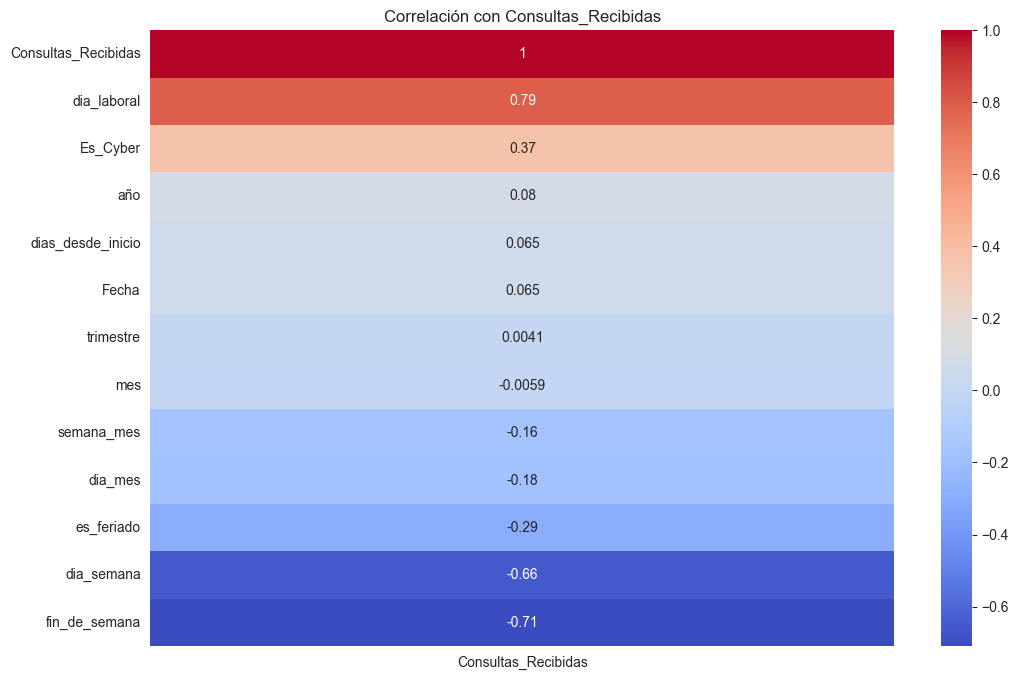

Evaluación en conjunto de prueba:
MAE: 157.36
MSE: 49159.47
RMSE: 221.72


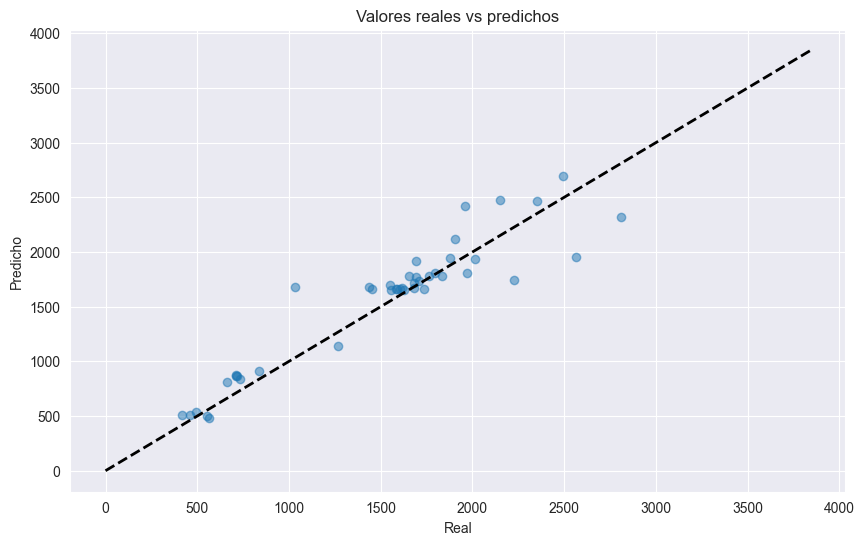

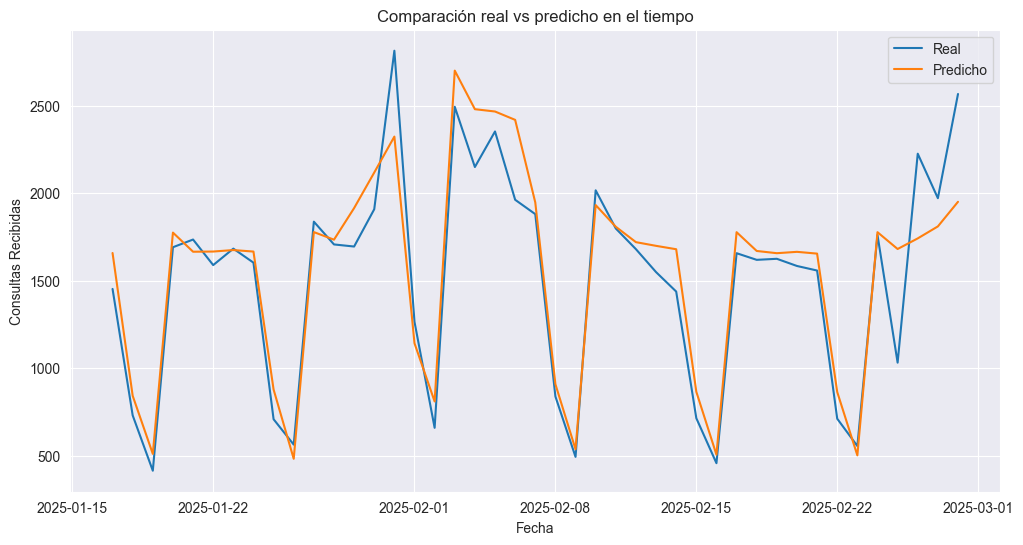

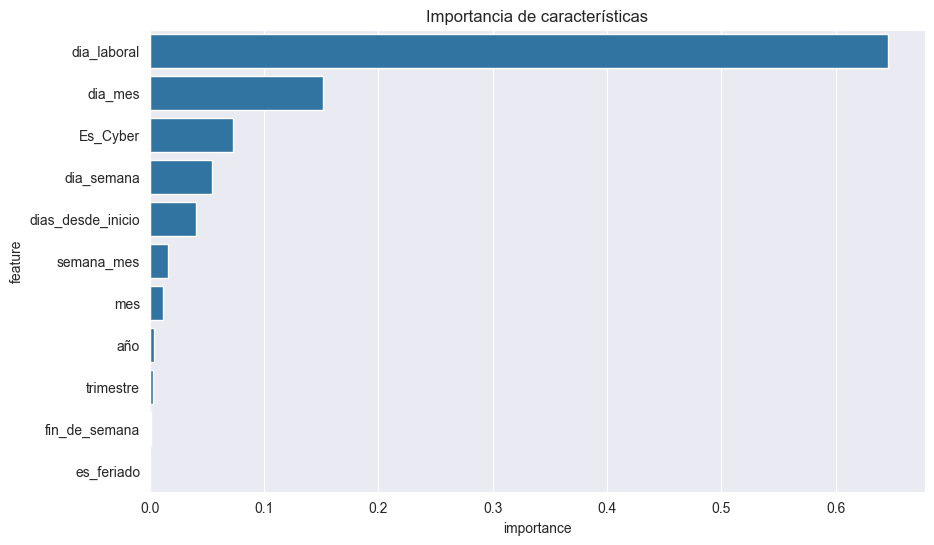


Modelo entrenado guardado en consultas_model.pkl


In [7]:
# data_modeling.ipynb

import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import holidays
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos limpios
with open(r'C:\Users\iazuaz\PyCharmMiscProject\model_RRSS\data\cleaned_data.pkl', 'rb') as f:
    df = pickle.load(f)

# Creación de características basadas en fecha
def create_date_features(df):
    # Día de la semana (0=lunes, 6=domingo)
    df['dia_semana'] = df['Fecha'].dt.dayofweek

    # Fin de semana (1 si es fin de semana, 0 si no)
    df['fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

    # Día del mes
    df['dia_mes'] = df['Fecha'].dt.day

    # Semana del mes
    df['semana_mes'] = df['Fecha'].apply(lambda x: (x.day-1)//7 + 1)

    # Mes
    df['mes'] = df['Fecha'].dt.month

    # Trimestre
    df['trimestre'] = df['Fecha'].dt.quarter

    # Año
    df['año'] = df['Fecha'].dt.year

    # Feriados en Chile (puedes ajustar según país)
    chile_holidays = holidays.CountryHoliday('CL')
    df['es_feriado'] = df['Fecha'].apply(lambda x: x in chile_holidays).astype(int)

    # Día laboral (no es fin de semana ni feriado)
    df['dia_laboral'] = ((df['fin_de_semana'] == 0) & (df['es_feriado'] == 0)).astype(int)

    # Días desde el inicio de los datos (tendencia)
    df['dias_desde_inicio'] = (df['Fecha'] - df['Fecha'].min()).dt.days

    return df

# Aplicar la función de creación de características
df = create_date_features(df)

# Visualizar la correlación de las nuevas características
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix[['Consultas_Recibidas']].sort_values('Consultas_Recibidas', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlación con Consultas_Recibidas')
plt.show()

# Dividir en características (X) y objetivo (y)
X = df.drop(['Consultas_Recibidas', 'Fecha'], axis=1)
y = df['Consultas_Recibidas']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Crear pipeline del modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Evaluar el modelo
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')

    # Gráfico de valores reales vs predichos
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Real')
    plt.ylabel('Predicho')
    plt.title('Valores reales vs predichos')
    plt.show()

    # Gráfico de serie temporal
    test_dates = df.iloc[X_test.index]['Fecha']
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Real')
    plt.plot(test_dates, y_pred, label='Predicho')
    plt.xlabel('Fecha')
    plt.ylabel('Consultas Recibidas')
    plt.title('Comparación real vs predicho en el tiempo')
    plt.legend()
    plt.show()

    return y_pred

print("Evaluación en conjunto de prueba:")
y_pred = evaluate_model(pipeline, X_test, y_test)

# Importancia de características
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Importancia de características')
plt.show()

# Guardar el modelo entrenado
with open(r'C:\Users\iazuaz\PyCharmMiscProject\model_RRSS\model\consultas_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("\nModelo entrenado guardado en consultas_model.pkl")

# Función para hacer predicciones futuras
def predict_future_days(model, last_date, days_to_predict):
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)
    future_df = pd.DataFrame({'Fecha': future_dates})

    # Crear características de fecha
    future_df = create_date_features(future_df)

    # Añadir Es_Cyber con valor 0 (asumimos no es cyber día)
    future_df['Es_Cyber'] = 0

    # Asegurarnos de que tenemos todas las columnas necesarias en el orden correcto
    expected_columns = X_train.columns
    for col in expected_columns:
        if col not in future_df.columns:
            future_df[col] = 0  # o valor por defecto apropiado

    # Reordenar columnas para que coincidan con el entrenamiento
    X_future = future_df[expected_columns]

    future_predictions = model.predict(X_future)
    future_df['Consultas_Recibidas_Pred'] = future_predictions
    return future_df[['Fecha', 'Consultas_Recibidas_Pred']]

# Save the trained model to a .pkl file
with open(r'C:\Users\iazuaz\PyCharmMiscProject\model_RRSS\model\consultas_model_v1.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [16]:
# Ejemplo de predicción para los próximos 30 días - CASO DE NECESITAR CAMBIAR CANTIDAD DE DÍAS A PRONOSTICAR, CAMBIAR EL VALOR DESPUÉS DE last_date, )
last_date = df['Fecha'].max()
future_predictions = predict_future_days(pipeline, last_date, 30)
print("\nPredicciones para los próximos 30 días:")
print(future_predictions)

# Redondear y convertir a entero
future_predictions['Consultas_Recibidas_Pred'] = future_predictions['Consultas_Recibidas_Pred'].round().astype(int)

# Opcional: Guardar predicciones futuras
future_predictions.to_csv('future_predictions.csv', index=False)
print("\nPredicciones futuras guardadas en future_predictions.csv")


Predicciones para los próximos 30 días:
        Fecha  Consultas_Recibidas_Pred
0  2025-03-01               1059.479171
1  2025-03-02                702.263146
2  2025-03-03               2372.238861
3  2025-03-04               2137.661944
4  2025-03-05               2105.185899
5  2025-03-06               2074.823968
6  2025-03-07               1706.511688
7  2025-03-08                851.598861
8  2025-03-09                517.043772
9  2025-03-10               1809.935437
10 2025-03-11               1610.520937
11 2025-03-12               1485.074689
12 2025-03-13               1463.294568
13 2025-03-14               1390.958546
14 2025-03-15                748.967552
15 2025-03-16                478.973083
16 2025-03-17               1577.963056
17 2025-03-18               1511.769521
18 2025-03-19               1517.034872
19 2025-03-20               1518.169990
20 2025-03-21               1427.839046
21 2025-03-22                711.904392
22 2025-03-23                476.113385

In [3]:
import pickle




NameError: name 'pipeline' is not defined